In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import random
import numpy as np
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.models import Sequential
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.metrics import accuracy_score

In [2]:
# Cargar el dataset MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalizar las imágenes (opcional pero recomendable)
x_train = x_train / 255.0
x_test = x_test / 255.0

# Ver forma de los datos
print("x_train:", x_train.shape, "y_train:", y_train.shape)
print("x_test:", x_test.shape, "y_test:", y_test.shape)

x_train: (60000, 28, 28) y_train: (60000,)
x_test: (10000, 28, 28) y_test: (10000,)


In [3]:
x_train = tf.reshape(x_train, (-1,28,28,1))
x_test = tf.reshape(x_test, (-1, 28,28,1))

print("x_train:", x_train.shape, "y_train:", y_train.shape)
print("x_test:", x_test.shape, "y_test:", y_test.shape)

x_train: (60000, 28, 28, 1) y_train: (60000,)
x_test: (10000, 28, 28, 1) y_test: (10000,)


2025-06-08 17:56:08.345856: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-06-08 17:56:08.345878: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-06-08 17:56:08.345882: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-06-08 17:56:08.345939: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-08 17:56:08.345973: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


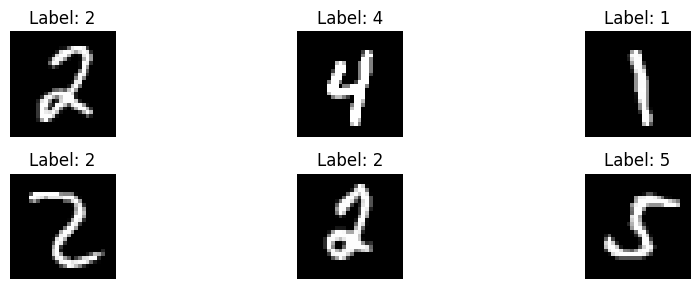

In [4]:
fig, axs = plt.subplots(2, 3, figsize=(10, 3))

for i in range(2):
    for j in range(3):
        idx_image = random.randint(0,len(x_train)-1)
        axs[i,j].imshow(x_train[idx_image], cmap='gray')
        axs[i,j].set_title(f"Label: {y_train[idx_image]}")
        axs[i,j].axis('off')

plt.tight_layout()
plt.show()

In [5]:
print("Before [y_train[0]]:",y_train[0])
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
print("After [y_train[0]]:",y_train[0])

Before [y_train[0]]: 5
After [y_train[0]]: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


# Data augmentation

In [6]:
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                             shear_range=0.2, zoom_range=0.1, horizontal_flip=False, fill_mode="nearest")
datagen.fit(x_train)

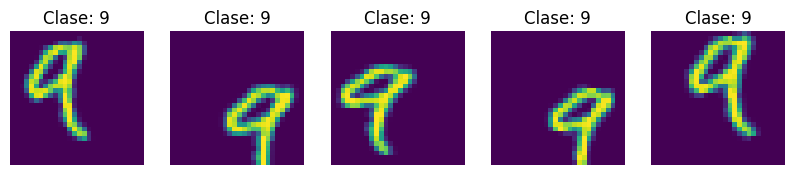

In [7]:
# Seleccionar una imagen de ejemplo
img = np.expand_dims(x_train[4], axis=0)  # Añadir dimensión batch

# Crear el iterador
augmented_generator = datagen.flow(img, batch_size=1)  # Generar imágenes de una en una

# Mostramos las 5 variaciones de una misma imagen
plt.figure(figsize=(10, 5))
for i in range(5):
    augmented_img = next(augmented_generator)[0]  # Obtener la imagen del generador
    plt.subplot(1, 5, i + 1)
    plt.imshow(augmented_img)  # Convertir a entero para mostrar correctamente
    plt.title(f"Clase: {np.argmax(y_train[4])}")
    plt.axis("off")
plt.show()

# CNN

In [8]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last',
                 input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', data_format='channels_last'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid', strides=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [9]:
#Optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )

#Compiling the model
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])


/Users/maciasalvasalva/miniconda3/envs/MachineLearning/lib/python3.10/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [10]:
#Define LearningRateScheduler
reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [11]:
batch_size = 64
epochs = 10

# Fit the Model
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size), epochs = epochs, 
                              validation_data = (x_test, y_test), verbose=1, 
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              callbacks = [reduce_lr]) #left out early_stopping parameter as it gets better accuracy

Epoch 1/10


/var/folders/pk/5lcc82957kv6k6hlpjcnblfr0000gn/T/ipykernel_8768/540997549.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size), epochs = epochs,
2025-06-08 17:56:09.601805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


935/937 [============================>.] - ETA: 0s - loss: 0.6091 - accuracy: 0.8182

2025-06-08 17:56:31.774664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


937/937 [==============================] - 25s 26ms/step - loss: 0.6080 - accuracy: 0.8185 - val_loss: 0.0801 - val_accuracy: 0.9734 - lr: 0.0010
Epoch 2/10
937/937 [==============================] - 24s 25ms/step - loss: 0.2007 - accuracy: 0.9398 - val_loss: 0.0789 - val_accuracy: 0.9753 - lr: 9.0000e-04
Epoch 3/10
937/937 [==============================] - 24s 26ms/step - loss: 0.1587 - accuracy: 0.9529 - val_loss: 0.0508 - val_accuracy: 0.9856 - lr: 8.1000e-04
Epoch 4/10
937/937 [==============================] - 24s 26ms/step - loss: 0.1347 - accuracy: 0.9603 - val_loss: 0.0445 - val_accuracy: 0.9868 - lr: 7.2900e-04
Epoch 5/10
937/937 [==============================] - 24s 25ms/step - loss: 0.1179 - accuracy: 0.9651 - val_loss: 0.0352 - val_accuracy: 0.9892 - lr: 6.5610e-04
Epoch 6/10
937/937 [==============================] - 24s 25ms/step - loss: 0.1098 - accuracy: 0.9675 - val_loss: 0.0410 - val_accuracy: 0.9873 - lr: 5.9049e-04
Epoch 7/10
937/937 [=============================

In [12]:
predictions = model.predict(x_test)
# Convertir las probabilidades a las clases predichas
predictions_classes = np.argmax(predictions, axis=-1)
# Ahora comparas las predicciones con las etiquetas reales (y_test)
accuracy = accuracy_score(np.argmax(y_test, axis=-1), predictions_classes)
print(f"Test accuracy: {accuracy}")

 30/313 [=>............................] - ETA: 0s

2025-06-08 18:00:08.067304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 4ms/step
Test accuracy: 0.9908


Text(0.5, 1.0, 'Accuracy Curves [CNN]')

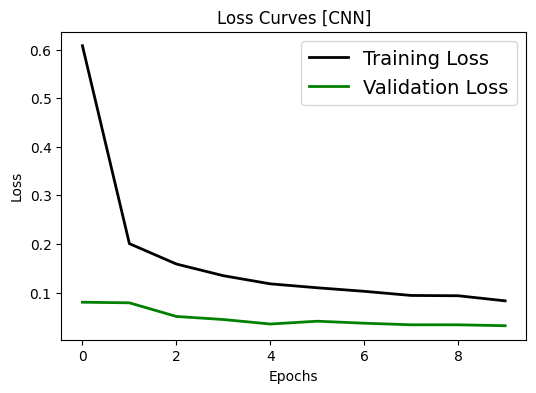

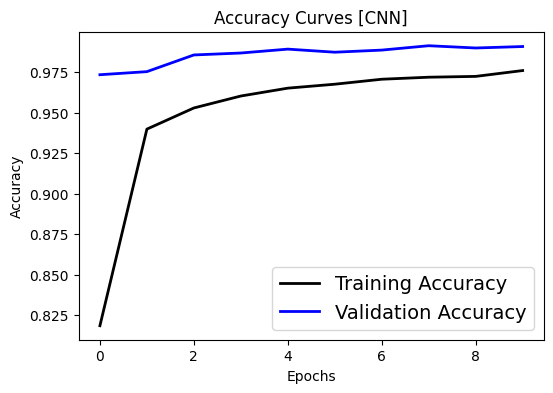

In [13]:
# Loss curve
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves [CNN]', fontsize=12)

plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves [CNN]', fontsize=12)

# Save model

In [14]:
model.save("modelo_completo_tf", save_format='tf')

INFO:tensorflow:Assets written to: modelo_completo_tf/assets


INFO:tensorflow:Assets written to: modelo_completo_tf/assets
